<a href="https://colab.research.google.com/github/kushagraagrawal/Kaggle/blob/master/Thales_Health.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import zipfile
with zipfile.ZipFile('gdrive/My Drive/Colab Notebooks/DataChallenge.zip', 'r') as zip_ref:
    zip_ref.extractall('dataChallenge')

In [0]:
!pip install tifffile

    100% |████████████████████████████████| 133kB 3.8MB/s 


In [0]:
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
import pandas as pd
import time
from math import *

In [0]:
def read_images(nameFile):
    """
    Return a list of images present in the .tiff file named 
    `nameFile` in the Data folder
    """
    dataImages = []
    scan = []
    try:
        scan = tiff.imread("dataChallenge/DataChallenge/"+nameFile) # load the images
    except:
        print("ERROR: file Data/" + nameFile + " not found!")
        return

    for element in range(len(scan)):
        image = scan[element, :,:,0] # Images are in gray scale
        dataImages.append(image)
        
    return dataImages

In [0]:
train_images = read_images("images_training.tiff")
print(len(train_images))

209933


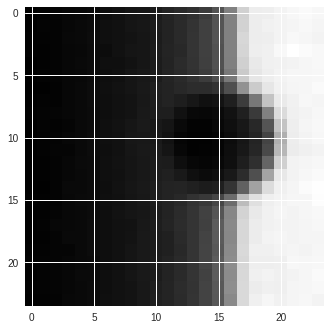

In [0]:
plt.imshow(train_images[100], cmap=plt.get_cmap('gray'))

In [0]:
descriptions = pd.read_csv("./dataChallenge/DataChallenge/descriptions_training.csv", header=None, 
                           names = ["nb_spots", 
                                    "x_first_spot", "y_first_spot",
                                    "x_second_spot", "y_second_spot"])

In [0]:
descriptions.head()

,nb_spots,x_first_spot,y_first_spot,x_second_spot,y_second_spot
0,1,18.877351,16.573234,0.0,0.0
1,1,10.159097,15.718106,0.0,0.0
2,1,9.441056,14.829910,0.0,0.0
3,0,0.000000,0.000000,0.0,0.0
4,0,0.000000,0.000000,0.0,0.0


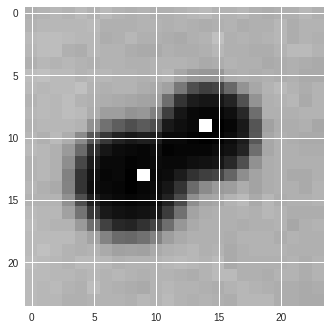

In [0]:
nImage = 16
image_copy = np.copy(train_images[nImage])
spot1 = descriptions.iloc[nImage, 1:3].values
spot2 = descriptions.iloc[nImage, 3:5].values
intensity = min( np.max(image_copy) + 20, 255)
if spot1[0] != 0 and spot1[1] != 0:
    image_copy[int(round(spot1[1]))][int(round(spot1[0]))] = intensity
if spot2[0] != 0 and spot2[1] != 0:
    image_copy[int(round(spot2[1]))][int(round(spot2[0]))] = intensity
plt.imshow(image_copy, cmap=plt.get_cmap('gray'))

In [0]:
def random_predict(images):
    """
    Return a DataFrame with a random pediciton for the `images` list.
    """
    rand_spot = np.random.randint(low = 0, high = 21, size = len(images))
    rand_location = np.random.random(len(images)) * 16 + 4
    answer =  pd.DataFrame(0, 
                           index=np.arange(len(images)), 
                           columns=["nb_spots", 
                                     "x_first_spot", "y_first_spot",
                                     "x_second_spot", "y_second_spot"])
    # Zero spot
    cond = (rand_spot) < 10
    answer.nb_spots[cond] = 0
    # One spot
    cond = (rand_spot >= 10) & (rand_spot < 20)
    answer.nb_spots[cond] = 1
    answer.x_first_spot[cond] = rand_location[cond]
    answer.y_first_spot[cond] = rand_location[cond]
    # Two spots
    cond = (rand_spot == 20)
    answer.nb_spots[cond] = 2
    answer.x_first_spot[cond] = rand_location[cond]
    answer.y_first_spot[cond] = rand_location[cond]
    answer.x_second_spot[cond] = rand_location[cond]
    answer.y_second_spot[cond] = rand_location[cond]
    return answer

In [0]:
train_prediction = random_predict(train_images)
train_prediction.groupby("nb_spots").mean()

,x_first_spot,y_first_spot,x_second_spot,y_second_spot
nb_spots,,,,
0,0.000000,0.000000,0.000000,0.000000
1,11.494896,11.494896,0.000000,0.000000
2,11.516867,11.516867,11.516867,11.516867


In [0]:
test_images = read_images("images_test.tiff")
test_prediction = random_predict(test_images)
test_prediction.groupby("nb_spots").mean()

,x_first_spot,y_first_spot,x_second_spot,y_second_spot
nb_spots,,,,
0,0.000000,0.000000,0.000000,0.000000
1,11.518428,11.518428,0.000000,0.000000
2,11.482404,11.482404,11.482404,11.482404


In [0]:
test_prediction.to_csv("answers.csv", header= False)

In [0]:
# function used to compute the score in the competition
## truth: the correct description of the spots
## observe: the compute description of the spots
def computeScore(truth, observe):
    alpha0 = 21/50.0
    alpha1 = 21/20.0
    alpha2 = 21*3/10
    assert len(truth) == len(observe)
    score = 0
    nb0 = 0
    nb1 = 0
    nb2 = 0
    for i in range(len(truth)):
        try :
            assert len(truth[i])==6
            assert len(observe[i])==6
        except:
            print(len(truth[i]))
            print(len(observe[i]))
            print(i)
            print("ERROR: the format of the file is wrong")
            return 1000000000000
        cur_truth = [int(truth[i][1]), float(truth[i][2]), float(truth[i][3]), float(truth[i][4]), float(truth[i][5])]
        cur_observe = [int(observe[i][1]), float(observe[i][2]), float(observe[i][3]), float(observe[i][4]), float(observe[i][5])]

        if cur_truth[0] == 0:
            score += alpha0 * f0(cur_truth, cur_observe)
            nb0 += 1
        elif cur_truth[0] == 1:
            score += alpha1 * f1(cur_truth, cur_observe)
            nb1 += 1
        elif cur_truth[0] == 2:
            score += alpha2 * f2(cur_truth, cur_observe)
            nb2 += 1
        else :
            score+=1
    return score/ (nb0 * alpha0 + nb1 * alpha1 + nb2 * alpha2)


# function to evaluate the score for image with zero spot
def f0(t, o):
    # print o[0]
    if o[0] == 0:
        return 0
    return 1

# function to evaluate the score for image with one spot
def f1(t,o):
    if o[0] == 0:
        return 1
    if o[0] == 1:
        return d(o[1],o[2],t[1],t[2])
    return ((1 + min(d(o[1], o[2], t[1], t[2]), d(o[3],o[4],t[1],t[2])))/ 2.0)

# function to evaluate the score for image with two spot
def f2(t,o):
    if o[0]==0:
        return 1
    if o[0] == 1:
        return ((1 + min(d(o[1], o[2], t[1], t[2]), d(o[1],o[2],t[3],t[4])))/ 2.0)
    return (min( d(o[1], o[2], t[1], t[2]) + d(o[3], o[4], t[3], t[4]) , d(o[1], o[2], t[3], t[4]) + d(o[3], o[4], t[1], t[2]) )/ 2.0)

# function of distance, evalue the quality of the detection
def d(x1, y1, x2, y2):
    dist = sqrt((x2-x1) * (x2-x1) + (y2-y1)*(y2-y1))
    if dist < 2:
        return ( (dist)/2.0)
    return 1

In [0]:
truth = descriptions.reset_index().values
find = train_prediction.reset_index().values
print(f'Score: {computeScore(truth, find)}')

Score: 0.8984613665914
